In [2]:
pip install pylibjpeg-libjpeg

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install dicom2jpg

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.utils  import to_categorical
import os
import pydicom
from pydicom import dcmread
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import dicom2jpg
import cv2
import pylibjpeg

# Läs in CSV Fil och lägg till plats för respektive bild

In [5]:
input_data = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

In [6]:
input_data = input_data[:500]

In [7]:
input_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,10512,457122509,R,CC,40.0,0,0,0,NaN,0,NaN,29,False
496,2,10512,474818568,R,MLO,40.0,0,0,0,NaN,0,NaN,29,False
497,2,10514,1196389201,L,CC,68.0,0,0,0,NaN,0,NaN,48,False
498,2,10514,1887797144,L,MLO,68.0,0,0,0,NaN,0,NaN,48,False


In [8]:
def filepath(row):
    file = str(input_data.patient_id[row]) +"/"+ str(input_data.image_id[row])+".dcm"
    file_path = os.path.join('../input/rsna-breast-cancer-detection/train_images/', file)
    return file_path

In [9]:
#import GDCM
from tqdm import tqdm

file_paths = []
for row in tqdm(range(len(input_data))):
    file_paths.append(filepath(row))


100%|██████████| 500/500 [00:00<00:00, 36571.43it/s]


In [10]:
input_data['image_path'] = file_paths

In [11]:
input_data.loc[:, ('patient_id','image_id', 'image_path')]


,patient_id,image_id,image_path
0,10006,462822612,../input/rsna-breast-cancer-detection/train_im...
1,10006,1459541791,../input/rsna-breast-cancer-detection/train_im...
2,10006,1864590858,../input/rsna-breast-cancer-detection/train_im...
3,10006,1874946579,../input/rsna-breast-cancer-detection/train_im...
4,10011,220375232,../input/rsna-breast-cancer-detection/train_im...
...,...,...,...
495,10512,457122509,../input/rsna-breast-cancer-detection/train_im...
496,10512,474818568,../input/rsna-breast-cancer-detection/train_im...
497,10514,1196389201,../input/rsna-breast-cancer-detection/train_im...
498,10514,1887797144,../input/rsna-breast-cancer-detection/train_im...


# Undersök datan

In [12]:
# Från https://www.kaggle.com/code/schlerp/getting-to-know-dicom-and-the-data/notebook
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print()

    print("Patient id..........:", dataset.PatientID)

    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: ../input/rsna-breast-cancer-detection/test_images/10008/736471439.dcm

Patient id..........: 10008
Image size.......: 2776 x 2082, 3643092 bytes


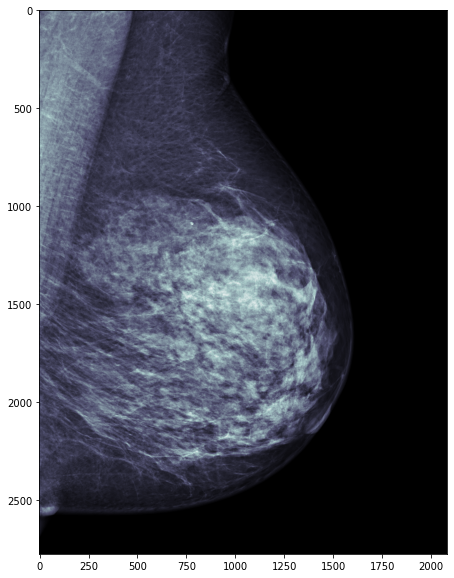

Filename.........: ../input/rsna-breast-cancer-detection/test_images/10008/361203119.dcm

Patient id..........: 10008
Image size.......: 2776 x 2082, 2723554 bytes


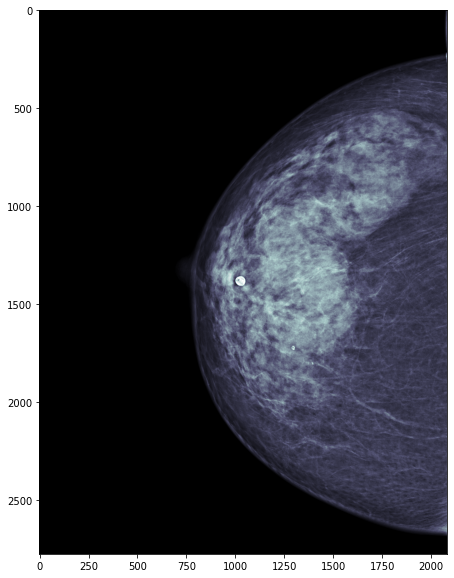

Filename.........: ../input/rsna-breast-cancer-detection/test_images/10008/68070693.dcm

Patient id..........: 10008
Image size.......: 2776 x 2082, 3584012 bytes


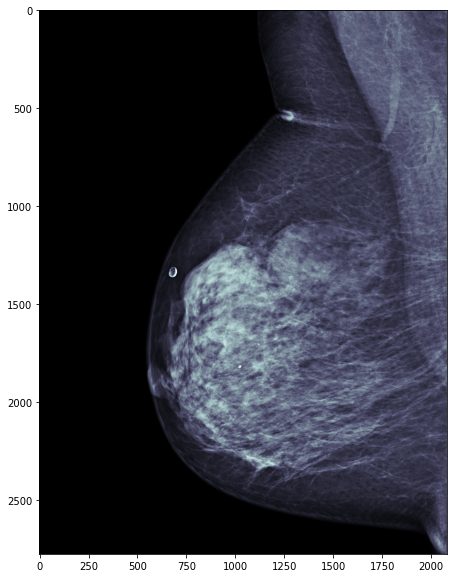

Filename.........: ../input/rsna-breast-cancer-detection/test_images/10008/1591370361.dcm

Patient id..........: 10008
Image size.......: 2776 x 2082, 2873866 bytes


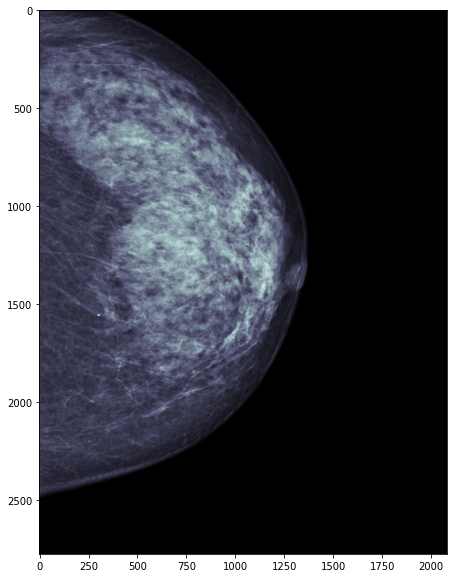

In [13]:
# Från https://www.kaggle.com/code/schlerp/getting-to-know-dicom-and-the-data/notebook
# Försök printa några bilder

i = 1
num_to_plot = 4
for file_name in os.listdir('../input/rsna-breast-cancer-detection/test_images/10008/'):
    file_path = os.path.join('../input/rsna-breast-cancer-detection/test_images/10008/', file_name)
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    if i >= num_to_plot:
        break
    
    i += 1

In [14]:
input_data.dtypes

site_id                      int64
patient_id                   int64
image_id                     int64
laterality                  object
view                        object
age                        float64
cancer                       int64
biopsy                       int64
invasive                     int64
BIRADS                     float64
implant                      int64
density                     object
machine_id                   int64
difficult_negative_case       bool
image_path                  object
dtype: object

In [15]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  500 non-null    int64  
 1   patient_id               500 non-null    int64  
 2   image_id                 500 non-null    int64  
 3   laterality               500 non-null    object 
 4   view                     500 non-null    object 
 5   age                      500 non-null    float64
 6   cancer                   500 non-null    int64  
 7   biopsy                   500 non-null    int64  
 8   invasive                 500 non-null    int64  
 9   BIRADS                   207 non-null    float64
 10  implant                  500 non-null    int64  
 11  density                  255 non-null    object 
 12  machine_id               500 non-null    int64  
 13  difficult_negative_case  500 non-null    bool   
 14  image_path               5

För age kommer jag ersätta de saknade värdena med medelåldern för resterande värden, men eftersom ca hälften saknas för BIRAS och density kommer jag bortse från de kolumnerna tills vidare. Om jag får problem kanske jag försöker göra något med dessa kolummer senare. 

In [16]:
input_data.drop(columns=["BIRADS", "density"], inplace=True)

In [17]:
mean_age = input_data["age"].mean()
input_data = input_data.fillna(mean_age)

In [18]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  500 non-null    int64  
 1   patient_id               500 non-null    int64  
 2   image_id                 500 non-null    int64  
 3   laterality               500 non-null    object 
 4   view                     500 non-null    object 
 5   age                      500 non-null    float64
 6   cancer                   500 non-null    int64  
 7   biopsy                   500 non-null    int64  
 8   invasive                 500 non-null    int64  
 9   implant                  500 non-null    int64  
 10  machine_id               500 non-null    int64  
 11  difficult_negative_case  500 non-null    bool   
 12  image_path               500 non-null    object 
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 47.5+ KB


In [19]:
input_data[input_data == 0].count()

site_id                      0
patient_id                   0
image_id                     0
laterality                   0
view                         0
age                          0
cancer                     490
biopsy                     470
invasive                   492
implant                    500
machine_id                   0
difficult_negative_case    447
image_path                   0
dtype: int64

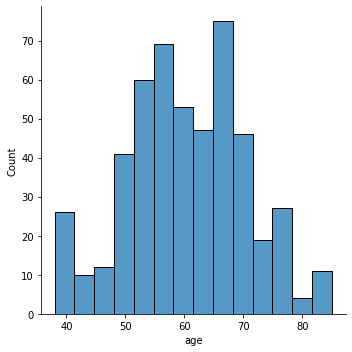

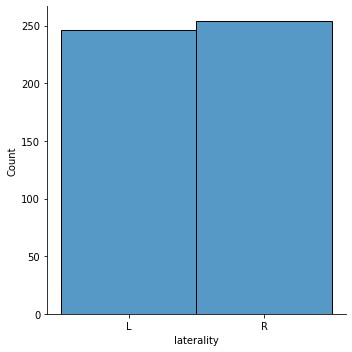

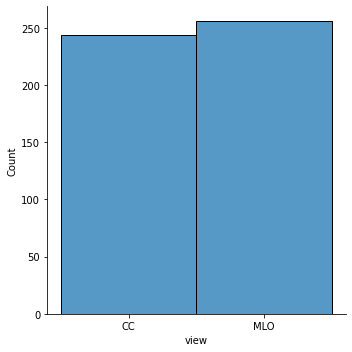

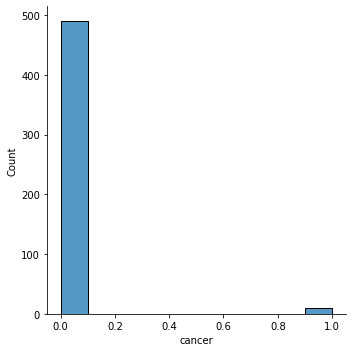

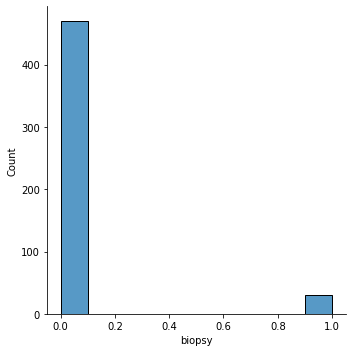

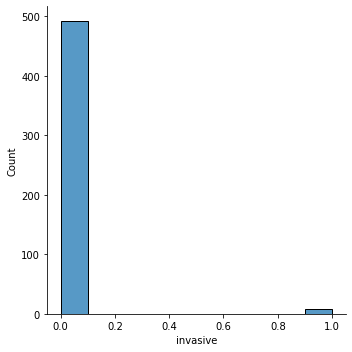

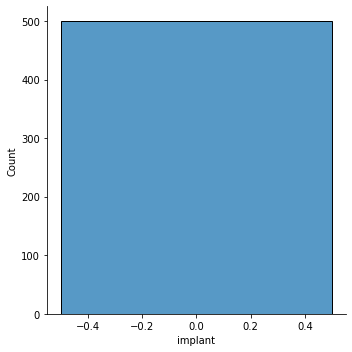

In [20]:
import seaborn as sns 
sns.displot(input_data.age)
sns.displot(input_data.laterality)
sns.displot(input_data.view)
sns.displot(input_data.cancer)
sns.displot(input_data.biopsy)
sns.displot(input_data.invasive)
sns.displot(input_data.implant)

# Dela in i Train, Test och Validation data

In [21]:
train_data, validation_data = train_test_split(input_data, train_size=0.7, random_state=42)

In [22]:
validation_data, test_data  = train_test_split(validation_data, train_size=0.7, random_state=42)

In [23]:
train_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case,image_path
5,2,10011,270344397,L,MLO,55.0,0,0,0,0,21,True,../input/rsna-breast-cancer-detection/train_im...
116,1,10151,1779471194,R,MLO,55.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...
45,1,10095,25264463,R,CC,38.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...
16,1,10042,102733848,L,CC,51.0,0,0,0,0,93,False,../input/rsna-breast-cancer-detection/train_im...
462,2,10487,1489925365,L,MLO,67.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2,10144,1260861056,L,MLO,68.0,0,0,0,0,21,False,../input/rsna-breast-cancer-detection/train_im...
270,2,10314,1055648343,R,MLO,60.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
348,2,10388,813841220,R,MLO,59.0,0,0,0,0,21,False,../input/rsna-breast-cancer-detection/train_im...
435,1,10442,2078023734,R,MLO,71.0,0,0,0,0,93,False,../input/rsna-breast-cancer-detection/train_im...


In [24]:
validation_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case,image_path
82,2,10126,1495487293,L,CC,53.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
271,2,10314,2040932567,R,MLO,60.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
24,2,10048,1842203124,R,CC,62.0,0,0,0,0,29,False,../input/rsna-breast-cancer-detection/train_im...
304,1,10335,1376911215,R,MLO,77.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...
132,2,10179,610638958,R,MLO,51.0,0,0,0,0,21,False,../input/rsna-breast-cancer-detection/train_im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2,10385,5847464,L,CC,62.0,0,0,0,0,21,False,../input/rsna-breast-cancer-detection/train_im...
301,1,10335,10344577,L,CC,77.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...
371,2,10404,359381091,R,CC,52.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
362,1,10399,1589397165,R,CC,64.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...


In [25]:
test_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case,image_path
290,2,10324,1430620887,R,MLO,82.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
316,2,10355,97437092,L,CC,67.0,0,0,0,0,29,False,../input/rsna-breast-cancer-detection/train_im...
117,1,10151,1827497738,R,CC,55.0,0,0,0,0,49,False,../input/rsna-breast-cancer-detection/train_im...
455,1,10483,1928261565,L,CC,49.0,0,0,0,0,49,True,../input/rsna-breast-cancer-detection/train_im...
268,2,10314,1537834356,L,CC,60.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
336,2,10366,1780242012,R,MLO,79.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
79,2,10124,473162373,R,MLO,75.0,0,0,0,0,48,False,../input/rsna-breast-cancer-detection/train_im...
208,2,10240,56090001,R,MLO,65.0,0,0,0,0,21,False,../input/rsna-breast-cancer-detection/train_im...
238,2,1028,1485541548,R,MLO,67.0,0,0,0,0,29,False,../input/rsna-breast-cancer-detection/train_im...
477,2,105,1232990271,L,MLO,57.0,0,0,0,0,29,False,../input/rsna-breast-cancer-detection/train_im...


In [26]:
train_input = train_data.drop('cancer', axis=1)
train_label = train_data['cancer']
val_input = validation_data.drop('cancer', axis=1)
val_label = validation_data['cancer']
test_input = test_data.drop('cancer', axis=1)
test_label = test_data['cancer']


In [27]:
# Modified code from Canvas
def rezised_np_array(filepaths):
    images = []
    for file_path in filepaths:
        img_data = dicom2jpg.dicom2img(file_path)
        resized_img = cv2.resize(img_data, dsize=(800, 960))
        #add an empty colour diention
        resized_img = np.expand_dims(resized_img, -1)

        images.append(resized_img)
    return images

# Define a Sequence generator
class Mygenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # transform the images to fit the model constraints
        image_paths = batch_x['image_path']
        x=rezised_np_array(image_paths)
        return np.array(x), np.array(batch_y)


In [28]:
file = str(input_data.patient_id[12]) +"/"+ str(input_data.image_id[12])+".dcm"
file_path = os.path.join('../input/rsna-breast-cancer-detection/train_images/', file)

#converts dicom image to numpy array and resizes it
img_data = dicom2jpg.dicom2img(file_path)
resized_img = cv2.resize(img_data, dsize=(800,960))
resized_img = np.expand_dims(resized_img, -1)



2023-01-15 09:44:47.145553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:44:47.146547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:44:47.341611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:44:47.342469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:44:47.343359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 960, 800, 16)      160       
_________________________________________________________________
flatten (Flatten)            (None, 12288000)          0         
_________________________________________________________________
dense (Dense)                (None, 16)                196608016 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 196,608,193
Trainable params: 196,608,193
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/dicom2jpg/utils.py:123: RuntimeWarning: invalid value encountered in true_divide
  pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
2023-01-15 09:45:28.318335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2023-01-15 09:46:08.273150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 622s 52s/step - loss: 4374.9058 - binary_accuracy: 0.9257 - val_loss: 0.0659 - val_binary_accuracy: 1.0000
Epoch 2/7
12/12 [==============================] - 545s 46s/step - loss: 846.9471 - binary_accuracy: 0.9743 - val_loss: 0.2500 - val_binary_accuracy: 1.0000
Epoch 3/7
12/12 [==============================] - 543s 47s/step - loss: 272.6321 - binary_accuracy: 0.9514 - val_loss: 0.2085 - val_binary_accuracy: 1.0000
Epoch 4/7
12/12 [==============================] - 542s 47s/step - loss: 43.8421 - binary_accuracy: 0.9800 - val_loss: 0.2462 - val_binary_accuracy: 1.0000
Epoch 5/7
12/12 [==============================] - 546s 47s/step - loss: 1.8988 - binary_accuracy: 0.9771 - val_loss: 0.2475 - val_binary_accuracy: 1.0000
Epoch 6/7
12/12 [==============================] - 543s 46s/step - loss: 0.6040 - binary_accuracy: 0.9771 - val_loss: 0.2523 - val_binary_accuracy: 1.0000
Epoch 7/7
2/2 [==============================] - 58s 20s/step - loss: 37

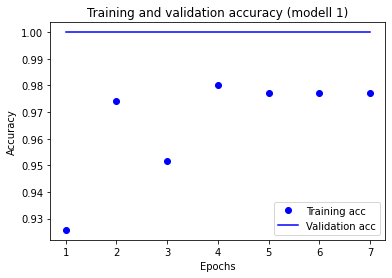

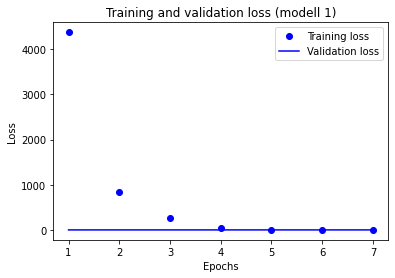

In [29]:
input_shape = resized_img.shape

model = Sequential([
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
Flatten(),
Dense(units=16, activation='relu'),
Dense(units=1, activation='sigmoid')
])
model.summary()

# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['binary_accuracy']
)

# Train the model
# Generate data streams from data sets
epochs =7       ## Number of epoch to run
batch_size = 30
train_gen = Mygenerator(train_input, train_label, batch_size = batch_size )
val_gen = Mygenerator(val_input, val_label, batch_size = batch_size )
test_gen = Mygenerator(test_input, test_label, batch_size = batch_size )

# Training using streams
history = model.fit(
    train_gen, 
    epochs=epochs, 
    shuffle=True, 
    verbose=1, 
    validation_data=val_gen) 

# Evaluate
test_loss, test_acc = model.evaluate(test_gen)

epochrange = range(1, epochs + 1)
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
